### Import Packages

In [1]:
# filter warnings
import warnings
warnings.filterwarnings('ignore')

#import plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import string
import logging
import pandas as pd
import numpy as np
import re

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import metrics


import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.util import ngrams


from collections import Counter
from nltk.probability import FreqDist

from sklearn.linear_model import LogisticRegressionCV,LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

#TextBlob
from textblob import TextBlob
from textblob import Word


In [2]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint("test pretty print which will be helpful for json and list variable")

'test pretty print which will be helpful for json and list variable'


### Understanding the Data

In [3]:
data=pd.read_json('reviews_Office_Products_5.json',lines=True)
data.head()

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00000JBLH,"[3, 4]",5,"I bought my first HP12C in about 1984 or so, a...","09 3, 2004",A32T2H8150OJLU,ARH,"A solid performer, and long time friend",1094169600
1,B00000JBLH,"[7, 9]",5,WHY THIS BELATED REVIEW? I feel very obliged t...,"12 15, 2007",A3MAFS04ZABRGO,"Let it Be ""Alan""","Price of GOLD is up, so don't bury the golden ...",1197676800
2,B00000JBLH,"[3, 3]",2,I have an HP 48GX that has been kicking for mo...,"01 1, 2011",A1F1A0QQP2XVH5,Mark B,"Good functionality, but not durable like old HPs",1293840000
3,B00000JBLH,"[7, 8]",5,I've started doing more finance stuff recently...,"04 19, 2006",A49R5DBXXQDE5,R. D Johnson,One of the last of an almost extinct species,1145404800
4,B00000JBLH,"[0, 0]",5,For simple calculations and discounted cash fl...,"08 4, 2013",A2XRMQA6PJ5ZJ8,Roger J. Buffington,Still the best,1375574400


In [4]:
data['overall'] = data['overall'].astype(object) # fix datatype error
dataset = {"reviewText": data["reviewText"], "overall": data["overall"]  }
dataset = pd.DataFrame(data = dataset)
dataset = dataset.dropna()
dataset.head()

,reviewText,overall
0,"I bought my first HP12C in about 1984 or so, a...",5
1,WHY THIS BELATED REVIEW? I feel very obliged t...,5
2,I have an HP 48GX that has been kicking for mo...,2
3,I've started doing more finance stuff recently...,5
4,For simple calculations and discounted cash fl...,5


In [5]:
dataset.dtypes

reviewText    object
overall       object
dtype: object

In [6]:
dataset['overall']=dataset['overall'].astype('int64')
dataset = dataset[dataset["overall"] != 3] # need datatype=object
dataset.shape

(48198, 2)

In [7]:
dataset["label"] = dataset["overall"].apply(lambda x : 1 if x > 3 else 0)
dataset[dataset["label"].isnull()]

,reviewText,overall,label


In [8]:
dataset.head()

,reviewText,overall,label
0,"I bought my first HP12C in about 1984 or so, a...",5,1
1,WHY THIS BELATED REVIEW? I feel very obliged t...,5,1
2,I have an HP 48GX that has been kicking for mo...,2,0
3,I've started doing more finance stuff recently...,5,1
4,For simple calculations and discounted cash fl...,5,1


In [9]:
dataset.label.value_counts()

1    45342
0     2856
Name: label, dtype: int64

In [10]:
dataset.overall.value_counts()

5    30327
4    15015
2     1726
1     1130
Name: overall, dtype: int64

In [11]:
stop_words=set(stopwords.words("english"))

dataset['reviewText']=dataset['reviewText'].str.lower()

dataset['sentence']=dataset['reviewText'].apply(lambda x: sent_tokenize(x))

dataset['tokens']=dataset['reviewText'].apply(lambda x: word_tokenize(x))

In [12]:
def get_clean_token_list(words):
    clean_words=[]
    for word in words:
        flag=True
        for letter in word:
            if letter.isdigit() or letter in string.punctuation:
                flag=False
        if flag:
            clean_words.append(word)
    return clean_words

print(get_clean_token_list(["hewy","ho!w","are","yo6u","?dd","111","qwerty"]))

def remove_stopwords(words):
    """
    pass series get series
    """
    filtered_sent=[]
    for word in words:
        if word not in stop_words:
            filtered_sent.append(word)
    return filtered_sent


print(remove_stopwords(["hey","how","are","you","?"]))

['hewy', 'are', 'qwerty']
['hey', '?']


In [13]:
dataset['tokens']=dataset['tokens'].apply(remove_stopwords)

dataset['tokens'].head()

0    [bought, first, hp12c, 1984, ,, served, faithf...
1    [belated, review, ?, feel, obliged, share, vie...
2    [hp, 48gx, kicking, twenty, years, hp, 11, 25,...
3    ['ve, started, finance, stuff, recently, went,...
4    [simple, calculations, discounted, cash, flows...
Name: tokens, dtype: object

In [14]:
dataset['tokens']=dataset['tokens'].apply(get_clean_token_list)

dataset['tokens'].head()

0    [bought, first, served, faithfully, lost, trav...
1    [belated, review, feel, obliged, share, views,...
2    [hp, kicking, twenty, years, hp, years, old, s...
3    [started, finance, stuff, recently, went, look...
4    [simple, calculations, discounted, cash, flows...
Name: tokens, dtype: object

In [15]:
stem = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

def stem_sentence(sentence):
    stem_sentence=[]
    for word in sentence:
        stem_sentence.append(stem.stem(word))
    return stem_sentence

def lemmatize_sentence(sentence):
    lem_sentence=[]
    for word in sentence:
        lem_sentence.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
    return lem_sentence

In [16]:
dataset.head()

,reviewText,overall,label,sentence,tokens
0,"i bought my first hp12c in about 1984 or so, a...",5,1,"[i bought my first hp12c in about 1984 or so, ...","[bought, first, served, faithfully, lost, trav..."
1,why this belated review? i feel very obliged t...,5,1,"[why this belated review?, i feel very obliged...","[belated, review, feel, obliged, share, views,..."
2,i have an hp 48gx that has been kicking for mo...,2,0,[i have an hp 48gx that has been kicking for m...,"[hp, kicking, twenty, years, hp, years, old, s..."
3,i've started doing more finance stuff recently...,5,1,[i've started doing more finance stuff recentl...,"[started, finance, stuff, recently, went, look..."
4,for simple calculations and discounted cash fl...,5,1,[for simple calculations and discounted cash f...,"[simple, calculations, discounted, cash, flows..."


In [17]:
dataset['stem_sentence']=dataset['tokens'].apply(lambda x: stem_sentence(x))

dataset[['tokens','stem_sentence']].head(10)

dataset['lemm_sentence']=dataset['tokens'].apply(lambda x: lemmatize_sentence(x))

dataset[['tokens','lemm_sentence']].head(10)

,tokens,lemm_sentence
0,"[bought, first, served, faithfully, lost, trav...","[buy, first, serve, faithfully, lose, travel, ..."
1,"[belated, review, feel, obliged, share, views,...","[belated, review, feel, oblige, share, view, o..."
2,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, kick, twenty, years, hp, years, old, stil..."
3,"[started, finance, stuff, recently, went, look...","[start, finance, stuff, recently, go, look, go..."
4,"[simple, calculations, discounted, cash, flows...","[simple, calculations, discount, cash, flow, o..."
5,"[mba, hard, believe, calculator, learned, use,...","[mba, hard, believe, calculator, learn, use, u..."
6,"[hp, ever, since, first, available, roughly, t...","[hp, ever, since, first, available, roughly, t..."
7,"[bought, boss, lost, loves, calculator, would,...","[buy, boss, lose, love, calculator, would, cat..."
8,"[simple, calculator, handles, typical, math, l...","[simple, calculator, handle, typical, math, la..."
9,"[love, calculator, big, numbers, calculate, ex...","[love, calculator, big, number, calculate, exc..."


In [18]:
dataset.head()

,reviewText,overall,label,sentence,tokens,stem_sentence,lemm_sentence
0,"i bought my first hp12c in about 1984 or so, a...",5,1,"[i bought my first hp12c in about 1984 or so, ...","[bought, first, served, faithfully, lost, trav...","[bought, first, serv, faith, lost, travel, sea...","[buy, first, serve, faithfully, lose, travel, ..."
1,why this belated review? i feel very obliged t...,5,1,"[why this belated review?, i feel very obliged...","[belated, review, feel, obliged, share, views,...","[belat, review, feel, oblig, share, view, old,...","[belated, review, feel, oblige, share, view, o..."
2,i have an hp 48gx that has been kicking for mo...,2,0,[i have an hp 48gx that has been kicking for m...,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, kick, twenti, year, hp, year, old, still,...","[hp, kick, twenty, years, hp, years, old, stil..."
3,i've started doing more finance stuff recently...,5,1,[i've started doing more finance stuff recentl...,"[started, finance, stuff, recently, went, look...","[start, financ, stuff, recent, went, look, goo...","[start, finance, stuff, recently, go, look, go..."
4,for simple calculations and discounted cash fl...,5,1,[for simple calculations and discounted cash f...,"[simple, calculations, discounted, cash, flows...","[simpl, calcul, discount, cash, flow, one, sti...","[simple, calculations, discount, cash, flow, o..."


In [19]:
reviews=[word for review in dataset['lemm_sentence'] for word in review]

fdist_reviews = FreqDist(reviews)

fdist_reviews.most_common(10)

[('use', 61375),
 ('print', 30238),
 ('printer', 29298),
 ('one', 27926),
 ('paper', 26963),
 ('like', 26040),
 ('work', 24809),
 ('get', 24176),
 ('make', 22934),
 ('label', 21503)]

In [20]:
positive_reviews=dataset[dataset['label']==1]['lemm_sentence']

positive_tokens=[word for review in positive_reviews for word in review]

fdist_positive_tokens = FreqDist(positive_tokens)

fdist_positive_tokens.most_common(10)

[('use', 58058),
 ('print', 28033),
 ('printer', 26633),
 ('one', 25759),
 ('paper', 25196),
 ('like', 24400),
 ('work', 22932),
 ('get', 21847),
 ('make', 21464),
 ('label', 20859)]

In [21]:
negative_reviews=dataset[dataset['label']==0]['lemm_sentence']

negative_reviews=[word for review in negative_reviews for word in review]

fdist_neagtive_tokens = FreqDist(negative_reviews)

fdist_neagtive_tokens.most_common(10)

[('use', 3317),
 ('printer', 2665),
 ('get', 2329),
 ('print', 2205),
 ('one', 2167),
 ('would', 1954),
 ('work', 1877),
 ('paper', 1767),
 ('ink', 1652),
 ('like', 1640)]

In [22]:
len(fdist_neagtive_tokens.most_common())

10454

In [23]:
len(fdist_positive_tokens.most_common())

32915

In [24]:
frequency_tokens={ x[0]:x[1] for x in fdist_positive_tokens.most_common()}

In [25]:
dataset['pos_tag']=dataset['tokens'].apply(lambda x: nltk.pos_tag(x))

dataset['pos_tag'].head()

0    [(bought, VBD), (first, RB), (served, VBN), (f...
1    [(belated, VBN), (review, NN), (feel, NN), (ob...
2    [(hp, NN), (kicking, VBG), (twenty, CD), (year...
3    [(started, VBN), (finance, NN), (stuff, NN), (...
4    [(simple, JJ), (calculations, NNS), (discounte...
Name: pos_tag, dtype: object

In [26]:
dataset.head()

,reviewText,overall,label,sentence,tokens,stem_sentence,lemm_sentence,pos_tag
0,"i bought my first hp12c in about 1984 or so, a...",5,1,"[i bought my first hp12c in about 1984 or so, ...","[bought, first, served, faithfully, lost, trav...","[bought, first, serv, faith, lost, travel, sea...","[buy, first, serve, faithfully, lose, travel, ...","[(bought, VBD), (first, RB), (served, VBN), (f..."
1,why this belated review? i feel very obliged t...,5,1,"[why this belated review?, i feel very obliged...","[belated, review, feel, obliged, share, views,...","[belat, review, feel, oblig, share, view, old,...","[belated, review, feel, oblige, share, view, o...","[(belated, VBN), (review, NN), (feel, NN), (ob..."
2,i have an hp 48gx that has been kicking for mo...,2,0,[i have an hp 48gx that has been kicking for m...,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, kick, twenti, year, hp, year, old, still,...","[hp, kick, twenty, years, hp, years, old, stil...","[(hp, NN), (kicking, VBG), (twenty, CD), (year..."
3,i've started doing more finance stuff recently...,5,1,[i've started doing more finance stuff recentl...,"[started, finance, stuff, recently, went, look...","[start, financ, stuff, recent, went, look, goo...","[start, finance, stuff, recently, go, look, go...","[(started, VBN), (finance, NN), (stuff, NN), (..."
4,for simple calculations and discounted cash fl...,5,1,[for simple calculations and discounted cash f...,"[simple, calculations, discounted, cash, flows...","[simpl, calcul, discount, cash, flow, one, sti...","[simple, calculations, discount, cash, flow, o...","[(simple, JJ), (calculations, NNS), (discounte..."


In [27]:
# keep only noun adjective and adverb
keep_tags=["JJ","JJR","JJS","RB","RBR","RBS","UH","NN","NNS","NNP","NNPS"]

def filter_tag(pos_list):
    pos_clean_list=[]
    for t in pos_list:
        if t[1] in keep_tags:
            pos_clean_list.append(t[0])
    return pos_clean_list

filter_tag([('asked', 'RB'), ('review', 'NN'), ('scale', 'RBS')])

['asked', 'review', 'scale']

In [28]:
dataset['filter_pos_tag']=dataset['pos_tag'].apply(filter_tag)

dataset[['tokens','filter_pos_tag']].head(10)

,tokens,filter_pos_tag
0,"[bought, first, served, faithfully, lost, trav...","[first, faithfully, travelling, difficult, com..."
1,"[belated, review, feel, obliged, share, views,...","[review, feel, share, views, old, workhorse, g..."
2,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, years, years, old, still, flawless, month..."
3,"[started, finance, stuff, recently, went, look...","[finance, stuff, recently, good, calculator, p..."
4,"[simple, calculations, discounted, cash, flows...","[simple, calculations, cash, flows, still, bes..."
5,"[mba, hard, believe, calculator, learned, use,...","[mba, hard, calculator, use, undergraduate, bu..."
6,"[hp, ever, since, first, available, roughly, t...","[hp, ever, first, available, roughly, years, a..."
7,"[bought, boss, lost, loves, calculator, would,...","[boss, loves, calculator, really, helps, day, ..."
8,"[simple, calculator, handles, typical, math, l...","[simple, calculator, handles, typical, math, l..."
9,"[love, calculator, big, numbers, calculate, ex...","[love, calculator, big, numbers, excellent, ea..."


In [29]:
dataset['clean_sentence']=dataset['filter_pos_tag'].apply(lambda x: ' '.join(x))

In [30]:
dataset.head()

,reviewText,overall,label,sentence,tokens,stem_sentence,lemm_sentence,pos_tag,filter_pos_tag,clean_sentence
0,"i bought my first hp12c in about 1984 or so, a...",5,1,"[i bought my first hp12c in about 1984 or so, ...","[bought, first, served, faithfully, lost, trav...","[bought, first, serv, faith, lost, travel, sea...","[buy, first, serve, faithfully, lose, travel, ...","[(bought, VBD), (first, RB), (served, VBN), (f...","[first, faithfully, travelling, difficult, com...",first faithfully travelling difficult come are...
1,why this belated review? i feel very obliged t...,5,1,"[why this belated review?, i feel very obliged...","[belated, review, feel, obliged, share, views,...","[belat, review, feel, oblig, share, view, old,...","[belated, review, feel, oblige, share, view, o...","[(belated, VBN), (review, NN), (feel, NN), (ob...","[review, feel, share, views, old, workhorse, g...",review feel share views old workhorse gold ann...
2,i have an hp 48gx that has been kicking for mo...,2,0,[i have an hp 48gx that has been kicking for m...,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, kick, twenti, year, hp, year, old, still,...","[hp, kick, twenty, years, hp, years, old, stil...","[(hp, NN), (kicking, VBG), (twenty, CD), (year...","[hp, years, years, old, still, flawless, month...",hp years years old still flawless months numbe...
3,i've started doing more finance stuff recently...,5,1,[i've started doing more finance stuff recentl...,"[started, finance, stuff, recently, went, look...","[start, financ, stuff, recent, went, look, goo...","[start, finance, stuff, recently, go, look, go...","[(started, VBN), (finance, NN), (stuff, NN), (...","[finance, stuff, recently, good, calculator, p...",finance stuff recently good calculator pleasan...
4,for simple calculations and discounted cash fl...,5,1,[for simple calculations and discounted cash f...,"[simple, calculations, discounted, cash, flows...","[simpl, calcul, discount, cash, flow, one, sti...","[simple, calculations, discount, cash, flow, o...","[(simple, JJ), (calculations, NNS), (discounte...","[simple, calculations, cash, flows, still, bes...",simple calculations cash flows still best used...


In [31]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
dataset_vector = vectorizer.fit_transform(dataset["clean_sentence"])


In [32]:
print(dataset_vector[0].shape)

(1, 35843)


In [33]:
print(dataset_vector.shape)

(48198, 35843)


In [34]:
dataset.shape

(48198, 10)

In [35]:
len(vectorizer.vocabulary_)

35843

In [36]:
vectorizer.vocabulary_

{'first': 11351,
 'faithfully': 10781,
 'travelling': 32470,
 'difficult': 8198,
 'come': 5686,
 'area': 1560,
 'buy': 3930,
 'hp': 14339,
 'mistake': 19042,
 'many': 18175,
 'people': 22259,
 'flagship': 11412,
 'line': 17367,
 'powerful': 23391,
 'extremely': 10660,
 'counterintuitive': 6691,
 'manual': 18141,
 'sketchy': 28313,
 'best': 2730,
 'hand': 13444,
 'way': 34696,
 'good': 12819,
 'sense': 27456,
 'solid': 28866,
 'reliable': 25558,
 'calculator': 4030,
 'basic': 2456,
 'statistics': 29653,
 'well': 34828,
 'business': 3869,
 'applications': 1441,
 'short': 27932,
 'ready': 25005,
 'move': 19446,
 'back': 2226,
 'old': 20821,
 'friend': 12061,
 'even': 10278,
 'batteries': 2498,
 'decade': 7499,
 'use': 33821,
 'home': 14145,
 'review': 26164,
 'feel': 11054,
 'share': 27700,
 'views': 34256,
 'workhorse': 35359,
 'gold': 12800,
 'anniversary': 1233,
 'year': 35628,
 'ower': 21475,
 'user': 33880,
 'fan': 10811,
 'especially': 10186,
 'frank': 11977,
 'successors': 30259,
 

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import chi2

vectorizer = CountVectorizer(token_pattern=r'\b\w+\b')
dataset_vector = vectorizer.fit_transform(dataset["clean_sentence"])


chi2_selector = chi2(dataset_vector, dataset['label'])

list_tokens=[]
for key, val in vectorizer.vocabulary_.items():    # for name, age in dictionary.iteritems():  (for Python 2.x)
        if key in frequency_tokens:
            list_tokens.append([key,val,frequency_tokens[key],chi2_selector[0][val],chi2_selector[1][val]])

In [38]:
df=pd.DataFrame(list_tokens,columns=['token','index','frquency','chi2_negative','chi2_positive'])

In [39]:
df.head()

,token,index,frquency,chi2_negative,chi2_positive
0,first,11351,6174,238.234734,9.541533e-54
1,faithfully,10781,15,7.799426,5.226283e-03
2,difficult,8198,1298,68.327256,1.384934e-16
3,come,5686,12807,0.005522,9.407616e-01
4,area,1560,1403,0.028180,8.666872e-01


In [40]:
df.sort_values(by='chi2_negative',ascending=False).head(20)

,token,index,frquency,chi2_negative,chi2_positive
1623,poor,23193,290,602.066043,5.948665e-133
3313,useless,33868,229,534.457101,3.028935e-118
2319,support,30438,1915,506.555338,3.561881e-112
889,printer,23795,26633,498.788952,1.743695e-110
160,customer,7208,488,473.954165,4.418971e-105
1626,refund,25403,35,453.144200,1.492299e-100
1475,worst,35419,97,438.232651,2.624770e-97
5163,defective,7608,63,436.568423,6.043607e-97
6,hp,14339,4094,406.527533,2.089302e-90
1737,terrible,31213,118,396.769820,2.780425e-88


In [41]:
df[df.token.str.contains('garbage')]
# significant
#frequency cutoff -5

,token,index,frquency,chi2_negative,chi2_positive
702,garbage,12371,109,106.774387,4.988463e-25


In [42]:
df.sort_values(by='chi2_positive',ascending=False).head(20)

,token,index,frquency,chi2_negative,chi2_positive
70,generation,12495,127,3.294806e-08,0.999855
1131,thank,31279,853,2.519429e-06,0.998734
216,last,16869,5419,4.529752e-06,0.998302
11523,scansnap,26976,257,4.932564e-06,0.998228
1754,considerably,6194,143,5.532551e-06,0.998123
4743,painless,21642,113,9.350670e-06,0.997560
1571,mice,18736,113,9.350670e-06,0.997560
2859,border,3319,301,2.137798e-05,0.996311
2749,sharpie,27740,951,3.319531e-05,0.995403
3132,hide,13970,352,4.096773e-05,0.994893


In [43]:
s='.'.join(list(dataset['clean_sentence']))

s = s.lower()
s = re.sub(r'[^a-zA-Z0-9\s]', ' ', s)
tokens = [token for token in s.split(" ") if token != ""]

# 2grams
bgs = nltk.bigrams(tokens)

#compute frequency distribution for all the bigrams in the text
bigram_fdist = nltk.FreqDist(bgs)
tmp_bigram_frequency_tokens={ x[0]:x[1] for x in bigram_fdist.most_common()}
# pp.pprint(bigram_frequency_tokens)

#3grams
bgs = nltk.trigrams(tokens)

#compute frequency distribution for all the trigrams in the text
trigram_fdist = nltk.FreqDist(bgs)
tmp_trigram_frequency_tokens={ x[0]:x[1] for x in trigram_fdist.most_common()}
# pp.pprint(trigram_frequency_tokens)

In [44]:
bigram_frequency_tokens={}
for key , value in tmp_bigram_frequency_tokens.items():
    bigram_frequency_tokens[key[0]+" "+key[1]]=value

trigram_frequency_tokens={}
for key , value in tmp_trigram_frequency_tokens.items():
    trigram_frequency_tokens[key[0]+" "+key[1]+" "+key[2]]=value

In [45]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', ngram_range=(2, 2))
dataset_vector = vectorizer.fit_transform(dataset["clean_sentence"])


chi2_selector = chi2(dataset_vector, dataset['label'])

list_tokens=[]
for key, val in vectorizer.vocabulary_.items():
        if key in bigram_frequency_tokens:
            list_tokens.append([key,val,bigram_frequency_tokens[key],chi2_selector[0][val],chi2_selector[1][val]])

In [46]:
bigram_df=pd.DataFrame(list_tokens,columns=['token','index','frquency','chi2_negative','chi2_positive'])

In [47]:
bigram_df.sort_values(by='chi2_negative',ascending=False).head(20)

,token,index,frquency,chi2_negative,chi2_positive
445,waste money,988038,80,459.335190,6.707576e-102
121021,tech support,906468,179,441.767763,4.463900e-98
55976,file box,313119,123,405.233990,3.995574e-90
35557,customer service,197756,282,246.823055,1.279557e-55
89192,piece junk,653318,35,246.406474,1.577187e-55
1231,buy store,108754,18,222.251159,2.919843e-50
198282,refillable cartridges,740584,20,196.863836,1.009810e-44
6924,best buy,70958,81,176.125224,3.400095e-40
450410,free postage,339931,15,175.420298,4.846464e-40
33291,poor quality,667768,73,161.985070,4.168220e-37


In [48]:
bigram_df.sort_values(by='chi2_positive',ascending=False).head(20)

,token,index,frquency,chi2_negative,chi2_positive
2849,well paper,997723,137,3.294806e-08,0.999855
21426,quality photo,717753,135,3.294806e-08,0.999855
20764,able easily,984,101,4.096773e-05,0.994893
65417,paper mate,620091,186,4.473247e-05,0.994664
6919,blank label,83710,17,5.692443e-05,0.993980
101159,product certainly,700902,17,5.692443e-05,0.993980
12078,website easy,992749,17,5.692443e-05,0.993980
430264,usb slot,965695,17,5.692443e-05,0.993980
40875,label much,456066,18,5.692443e-05,0.993980
32680,even machine,278747,17,5.692443e-05,0.993980


In [49]:
vectorizer = CountVectorizer(token_pattern=r'\b\w+\b', ngram_range=(3, 3))
dataset_vector = vectorizer.fit_transform(dataset["clean_sentence"])


chi2_selector = chi2(dataset_vector, dataset['label'])

list_tokens=[]
for key, val in vectorizer.vocabulary_.items():
        if key in trigram_frequency_tokens:
            list_tokens.append([key,val,trigram_frequency_tokens[key],chi2_selector[0][val],chi2_selector[1][val]])

In [50]:
trigram_df=pd.DataFrame(list_tokens,columns=['token','index','frquency','chi2_negative','chi2_positive'])

In [51]:
trigram_df.sort_values(by='chi2_negative',ascending=False).head(20)

,token,index,frquency,chi2_negative,chi2_positive
470847,best buy store,130038,14,222.264706,2.900045e-50
1344962,sheets full color,1607384,11,174.636555,7.187441e-40
1344963,color pages black,297157,12,158.255424,2.721635e-36
227814,pages black pages,1199675,15,122.267327,2.017390e-28
1287444,full color pages,654850,15,122.267327,2.017390e-28
244535,worst printer ever,2037452,11,113.655640,1.550228e-26
278480,printer time ink,1385829,8,95.498682,1.479898e-22
278494,great lengths sure,704137,6,95.256303,1.672648e-22
1345031,epson inks part,510835,6,95.256303,1.672648e-22
1345038,start last color,1720973,6,95.256303,1.672648e-22


In [52]:
trigram_df.sort_values(by='chi2_positive',ascending=False).head(20)

,token,index,frquency,chi2_negative,chi2_positive
5492,mouse pad great,1059875,17,0.000057,0.993980
37171,great label maker,703859,17,0.000057,0.993980
267292,pages minute black,1201878,17,0.000057,0.993980
15222,laser inkjet printer,900751,17,0.000057,0.993980
165374,review helpful please,1522109,17,0.000057,0.993980
68186,heavy duty plastic,745067,17,0.000057,0.993980
222128,print directly memory,1359813,17,0.000057,0.993980
542412,regular paper photo,1500595,17,0.000057,0.993980
137853,worth extra cost,2037853,17,0.000057,0.993980
673140,inch x inch,800868,17,0.000057,0.993980


In [53]:
def detect_polarity(col):
    return TextBlob(col).sentiment.polarity

def detect_subjectivity(col):
    return TextBlob(col).sentiment.subjectivity

def get_lemma(col):
    lemma_list = []
    text = TextBlob(col).words
    for item in text:
        lemma = Word(item).lemmatize()
        lemma_list.append(lemma)
    return lemma_list

def detect_sentence_polarity(col):
    scores = []
    for sentences in TextBlob(col).sentences:
        score = np.round(sentences.sentiment.polarity,2)
        scores.append(score)
    return scores

def sentence_count(col_name, sign = 'total'):
    # TODO : OPTIMIZE this
    count_list = []
    for reviews in col_name:
        total_count = len(reviews)
        if sign == 'total':
            count_list.append(total_count)
        else:
            count = 0
            for polarity in reviews:
                if sign == 'positive' and polarity >= 0.2 :
                    count += 1
                elif sign == 'neutral' and polarity >=0 and polarity<0.2:
                    count += 1
                elif sign == 'negative' and polarity <0 :
                    count += 1
            count_list.append(count)
    return count_list 



def negative_boolean(col):
    value = 0
    value_list = []
    for sentence in col:
        polarity = detect_polarity(sentence)
        if polarity < 0:
            value = 1
        else: 
            value = 0
        value_list.append(value)
    return value_list

filter_method = lambda x:'Highly Positive' if x >= 0.5 else 'Fairly Positive' if (x > 0 and x < 0.5) else 'Highly Negative' if x <= -0.5 else 'Fairly Negative' if (x > -0.5 and x < 0) else 'Neutral'

In [54]:
# dataset['polarity'] = round(dataset.reviewText.apply(detect_polarity),1)
# dataset['subjectivity'] = round(dataset.reviewText.apply(detect_subjectivity),1)
# dataset['sentiment'] = dataset['polarity'].apply(filter_method)
# dataset['lemma'] = dataset.reviewText.apply(get_lemma)

dataset['sentence_sentiment'] = dataset.reviewText.apply(detect_sentence_polarity)

dataset['#positive_sentences'] = sentence_count(dataset['sentence_sentiment'], 'positive')
dataset['#negative_sentences'] = sentence_count(dataset['sentence_sentiment'], 'negative')
dataset['#neutral_sentences']= sentence_count(dataset['sentence_sentiment'], 'neutral')

dataset['% positive_sentences'] =np.round(dataset['#positive_sentences']*100/(dataset['#positive_sentences']+dataset['#negative_sentences']+dataset['#neutral_sentences']),2)
dataset['% negative_sentences'] =np.round(dataset['#negative_sentences']*100/(dataset['#positive_sentences']+dataset['#negative_sentences']+dataset['#neutral_sentences']),2)
dataset['% neutral_sentences'] =np.round(dataset['#neutral_sentences']*100/(dataset['#positive_sentences']+dataset['#negative_sentences']+dataset['#neutral_sentences']),2)

dataset.head(6)

,reviewText,overall,label,sentence,tokens,stem_sentence,lemm_sentence,pos_tag,filter_pos_tag,clean_sentence,sentence_sentiment,#positive_sentences,#negative_sentences,#neutral_sentences,% positive_sentences,% negative_sentences,% neutral_sentences
0,"i bought my first hp12c in about 1984 or so, a...",5,1,"[i bought my first hp12c in about 1984 or so, ...","[bought, first, served, faithfully, lost, trav...","[bought, first, serv, faith, lost, travel, sea...","[buy, first, serve, faithfully, lose, travel, ...","[(bought, VBD), (first, RB), (served, VBN), (f...","[first, faithfully, travelling, difficult, com...",first faithfully travelling difficult come are...,"[0.25, -0.5, 0.0, 0.0, 0.42, 0.19, 0.0, 0.25, ...",3,1,6,30.00,10.00,60.00
1,why this belated review? i feel very obliged t...,5,1,"[why this belated review?, i feel very obliged...","[belated, review, feel, obliged, share, views,...","[belat, review, feel, oblig, share, view, old,...","[belated, review, feel, oblige, share, view, o...","[(belated, VBN), (review, NN), (feel, NN), (ob...","[review, feel, share, views, old, workhorse, g...",review feel share views old workhorse gold ann...,"[0.0, 0.27, 0.0, 0.18, 0.7, -0.03, 0.08, 0.4, ...",8,1,9,44.44,5.56,50.00
2,i have an hp 48gx that has been kicking for mo...,2,0,[i have an hp 48gx that has been kicking for m...,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, kick, twenti, year, hp, year, old, still,...","[hp, kick, twenty, years, hp, years, old, stil...","[(hp, NN), (kicking, VBG), (twenty, CD), (year...","[hp, years, years, old, still, flawless, month...",hp years years old still flawless months numbe...,"[0.52, -0.16, 0.0, 0.07, 0.15, 0.6, 0.17, -0.35]",2,2,4,25.00,25.00,50.00
3,i've started doing more finance stuff recently...,5,1,[i've started doing more finance stuff recentl...,"[started, finance, stuff, recently, went, look...","[start, financ, stuff, recent, went, look, goo...","[start, finance, stuff, recently, go, look, go...","[(started, VBN), (finance, NN), (stuff, NN), (...","[finance, stuff, recently, good, calculator, p...",finance stuff recently good calculator pleasan...,"[0.4, 0.25, 0.8, 0.38, 0.2, 0.0, 0.25, 0.35, 0...",25,5,12,59.52,11.90,28.57
4,for simple calculations and discounted cash fl...,5,1,[for simple calculations and discounted cash f...,"[simple, calculations, discounted, cash, flows...","[simpl, calcul, discount, cash, flow, one, sti...","[simple, calculations, discount, cash, flow, o...","[(simple, JJ), (calculations, NNS), (discounte...","[simple, calculations, cash, flows, still, bes...",simple calculations cash flows still best used...,"[0.5, 0.0, 0.18, 0.5, 0.72, 0.0, 0.0, 0.0]",3,0,5,37.50,0.00,62.50
5,"while i don't have an mba, it's hard to believ...",5,1,"[while i don't have an mba, it's hard to belie...","[mba, hard, believe, calculator, learned, use,...","[mba, hard, believ, calcul, learn, use, underg...","[mba, hard, believe, calculator, learn, use, u...","[(mba, RB), (hard, JJ), (believe, VBP), (calcu...","[mba, hard, calculator, use, undergraduate, bu...",mba hard calculator use undergraduate business...,"[0.01, 0.1, 0.17, 0.03, -0.02, 0.07, 0.0]",0,1,6,0.00,14.29,85.71


Polarity is float which lies within range of [-1,1]. Values closer to 1 have a highly positive sentiment and values closer to -1 have highly negative sentiment. Values closer to 0 on the either sides shows slighty positive and negative indication.

Similarly, subjective sentences refer to personal opinion, emotion or judgement whereas objective refers to facts. Subjectivity is also a float which lies in the range of [0,1]

In [55]:
dataset.head()

,reviewText,overall,label,sentence,tokens,stem_sentence,lemm_sentence,pos_tag,filter_pos_tag,clean_sentence,sentence_sentiment,#positive_sentences,#negative_sentences,#neutral_sentences,% positive_sentences,% negative_sentences,% neutral_sentences
0,"i bought my first hp12c in about 1984 or so, a...",5,1,"[i bought my first hp12c in about 1984 or so, ...","[bought, first, served, faithfully, lost, trav...","[bought, first, serv, faith, lost, travel, sea...","[buy, first, serve, faithfully, lose, travel, ...","[(bought, VBD), (first, RB), (served, VBN), (f...","[first, faithfully, travelling, difficult, com...",first faithfully travelling difficult come are...,"[0.25, -0.5, 0.0, 0.0, 0.42, 0.19, 0.0, 0.25, ...",3,1,6,30.00,10.00,60.00
1,why this belated review? i feel very obliged t...,5,1,"[why this belated review?, i feel very obliged...","[belated, review, feel, obliged, share, views,...","[belat, review, feel, oblig, share, view, old,...","[belated, review, feel, oblige, share, view, o...","[(belated, VBN), (review, NN), (feel, NN), (ob...","[review, feel, share, views, old, workhorse, g...",review feel share views old workhorse gold ann...,"[0.0, 0.27, 0.0, 0.18, 0.7, -0.03, 0.08, 0.4, ...",8,1,9,44.44,5.56,50.00
2,i have an hp 48gx that has been kicking for mo...,2,0,[i have an hp 48gx that has been kicking for m...,"[hp, kicking, twenty, years, hp, years, old, s...","[hp, kick, twenti, year, hp, year, old, still,...","[hp, kick, twenty, years, hp, years, old, stil...","[(hp, NN), (kicking, VBG), (twenty, CD), (year...","[hp, years, years, old, still, flawless, month...",hp years years old still flawless months numbe...,"[0.52, -0.16, 0.0, 0.07, 0.15, 0.6, 0.17, -0.35]",2,2,4,25.00,25.00,50.00
3,i've started doing more finance stuff recently...,5,1,[i've started doing more finance stuff recentl...,"[started, finance, stuff, recently, went, look...","[start, financ, stuff, recent, went, look, goo...","[start, finance, stuff, recently, go, look, go...","[(started, VBN), (finance, NN), (stuff, NN), (...","[finance, stuff, recently, good, calculator, p...",finance stuff recently good calculator pleasan...,"[0.4, 0.25, 0.8, 0.38, 0.2, 0.0, 0.25, 0.35, 0...",25,5,12,59.52,11.90,28.57
4,for simple calculations and discounted cash fl...,5,1,[for simple calculations and discounted cash f...,"[simple, calculations, discounted, cash, flows...","[simpl, calcul, discount, cash, flow, one, sti...","[simple, calculations, discount, cash, flow, o...","[(simple, JJ), (calculations, NNS), (discounte...","[simple, calculations, cash, flows, still, bes...",simple calculations cash flows still best used...,"[0.5, 0.0, 0.18, 0.5, 0.72, 0.0, 0.0, 0.0]",3,0,5,37.50,0.00,62.50


In [56]:
dataset['% negative > % positive']=dataset['% negative_sentences']>dataset['% positive_sentences']
dataset['% negative > 10']=dataset['% negative_sentences']>10
dataset['% positive > 50']=dataset['% positive_sentences']>50

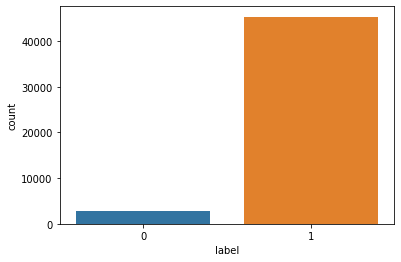

In [59]:
sns.countplot(x='label', data=dataset);

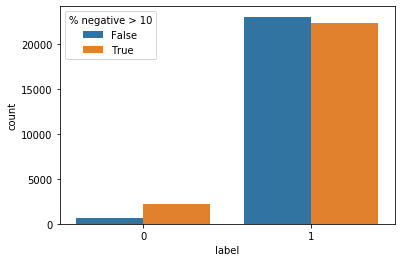

In [60]:
sns.countplot(x='label', data=dataset,hue='% negative > 10');

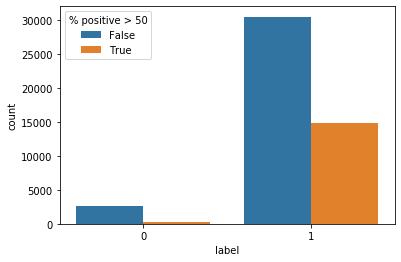

In [61]:
sns.countplot(x='label', data=dataset,hue='% positive > 50');

In [ ]:
dataset[dataset['label']==0]

In [ ]:
import math
import numpy as np
import pandas as pd
from collections import Counter


class TfIdfExtractor(object):

    def gen_tf_score(self, doc):
        return Counter(doc)

    def gen_df_score(self, doc_list):

        idf_corpus = {}
        doc_cntr = 0
        for doc in doc_list:
            ## TODO: Handle Bad docs
            if len(doc) == 0: continue

            doc_cntr += 1
            tf_doc = self.gen_tf_score(doc)
            idf_corpus.update(
                {_k: idf_corpus.get(_k, 0) + 1 for _k, _v in tf_doc.items()})  # Add for the presence of term
            #tf_doc = {_k: _v / len(doc) for _k, _v in tf_doc.items()}

        return idf_corpus, doc_cntr

    def gen_tf_idf_scores(self, doc_list):

        global_tfidf= {}

        # Obtain the document frequency scores
        df_scores, num_doc = self.gen_df_score(doc_list)

        for doc in doc_list:
            tf_doc = Counter(doc)

            for _term, _freq in tf_doc.items():
                _term_idf = df_scores.get(_term, 0)
                if _term_idf > 0:
                    tfidf_score = _freq * math.log10(num_doc / _term_idf)
                else:
                    raise Exception("TFIDF calculation failed!")

                if _term in global_tfidf:
                    global_tfidf[_term].append(tfidf_score)
                else:
                    global_tfidf[_term] = [tfidf_score]

                #global_tfidf[_term] = [tfidf_score]

        return global_tfidf

    def gen_tf_idf_stats_df(self, doc_list):

        global_tfidf = self.gen_tf_idf_scores(doc_list)

        tfidf_list = []
        for _term in global_tfidf:
            tfidf_dict = {}
            tfidf_scores = global_tfidf[_term]
            tfidf_dict['term'] = _term
            # tfidf_dict['mode'] = mode(tfidf_scores)
            tfidf_dict['mean'] = np.mean(tfidf_scores)
            tfidf_dict['median'] = np.median(tfidf_scores)
            tfidf_dict['min'] = min(tfidf_scores)
            tfidf_dict['max'] = max(tfidf_scores)
            tfidf_dict['freq'] = len(tfidf_scores)
            tfidf_list.append(tfidf_dict)

        tfidf_df = pd.DataFrame(tfidf_list)
        return tfidf_df

In [ ]:
# corp_proc_tokens = list(dataset[''])
# tfidf_df = TfIdfExtractor().gen_tf_idf_stats_df(corp_proc_tokens)

In [ ]:
dataset.iloc[:100,:].to_csv('amazon_text_review_features.csv',index=False)

In [ ]:
dataset[dataset['label']==0].to_csv('amazon_text_review_negative_features.csv',index=False)